# 🖼️ Image Color Correction with UNet

In this project, we use a **UNet-based neural network** for **image color correction**.  
The workflow includes:
1. Importing libraries  
2. Preparing the dataset  
3. Building the UNet model  
4. Training with Mixed Precision (AMP) and Gradient Clipping  
5. Evaluating on validation/test sets  
6. Visualizing predictions  
7. Saving the best model  


## 📦 Import Libraries


In [ ]:
import os
import joblib
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split
import torchvision.transforms as T

## 📂 Dataset Preparation
We prepare our dataset of images:
- **Raw images**: uncorrected inputs  
- **Target images**: ground truth corrected images  

We use a custom `Dataset` class and `DataLoader` for efficient batch processing.  


In [2]:
class ColorCorrectionDataset(Dataset):
    def __init__(self, root_dir, split="train", transform=None):
        self.raw_dir = os.path.join(root_dir, split, "raw")
        self.processed_dir = os.path.join(root_dir, split, "target")

        self.raw_files = sorted(os.listdir(self.raw_dir))
        self.processed_files = sorted(os.listdir(self.processed_dir))

        assert len(self.raw_files) == len(self.processed_files), "Mismatch in raw/processed counts!"
        self.transform = transform

    def __len__(self):
        return len(self.raw_files)

    def __getitem__(self, idx):
        raw_path = os.path.join(self.raw_dir, self.raw_files[idx])
        processed_path = os.path.join(self.processed_dir, self.processed_files[idx])

        raw_img = Image.open(raw_path).convert("RGB")
        processed_img = Image.open(processed_path).convert("RGB")

        if self.transform:
            raw_img = self.transform(raw_img)
            processed_img = self.transform(processed_img)

        return raw_img, processed_img

In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

In [4]:
root_dir="/kaggle/input/mitabovefivek/C"

In [ ]:
# Load datasets
train_dataset = ColorCorrectionDataset(root_dir, split="train", transform=transform)
test_dataset = ColorCorrectionDataset(root_dir, split="test", transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

In [6]:
print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 4750
Test samples: 250


# Check dataset structure and consistency 


In [ ]:
def check_dataset_structure(root_dir):
    for split in ["train", "test"]:
        raw_dir = os.path.join(root_dir, split, "raw")
        processed_dir = os.path.join(root_dir, split, "target")

        raw_files = sorted(os.listdir(raw_dir))
        processed_files = sorted(os.listdir(processed_dir))

        print(f"\n=== {split.upper()} SPLIT ===")
        print(f"Raw images: {len(raw_files)}")
        print(f"Processed images: {len(processed_files)}")

        if len(raw_files) != len(processed_files):
            print("Mismatch in counts!")
        else:
            print("Counts match!")

        # Check names
        mismatches = [(r, p) for r, p in zip(raw_files, processed_files) if r != p]
        if mismatches:
            print(f"Found {len(mismatches)} filename mismatches. Example: {mismatches[:5]}")
        else:
            print("Filenames match correctly!")

In [8]:
check_dataset_structure("/kaggle/input/mitabovefivek/C")


=== TRAIN SPLIT ===
Raw images: 4750
Processed images: 4750
Counts match!
Filenames match correctly!

=== TEST SPLIT ===
Raw images: 250
Processed images: 250
Counts match!
Filenames match correctly!


In [ ]:
# Split train dataset into training and validation sets

val_size = int(0.1 * len(train_dataset))  
train_size = len(train_dataset) - val_size  

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

In [10]:
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Train: 4275, Val: 475, Test: 250


In [11]:
def imshow(tensor, ax, title=None):
    image = tensor.permute(1, 2, 0).cpu().numpy()
    ax.imshow(image)
    ax.axis("off")
    if title:
        ax.set_title(title)

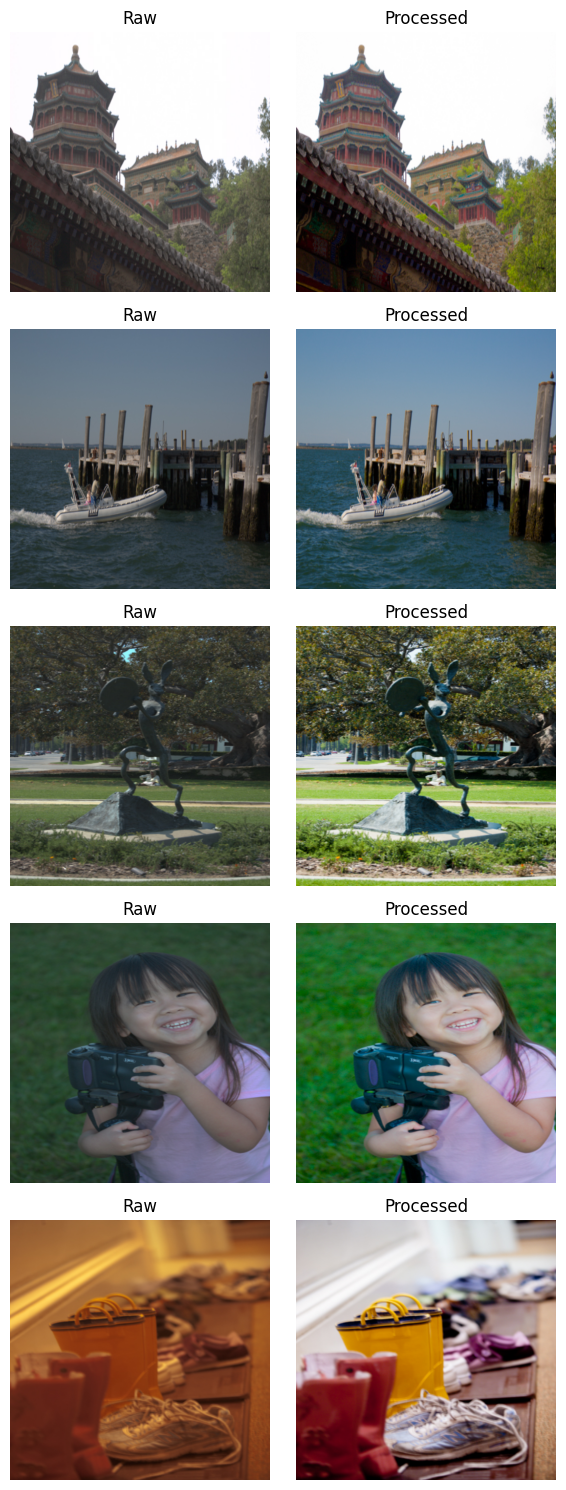

In [ ]:
# Visualize some samples

raw_imgs, processed_imgs = next(iter(train_loader))

fig, axes = plt.subplots(5, 2, figsize=(6, 15))  

for i in range(5):
    imshow(raw_imgs[i], axes[i, 0], title="Raw")
    imshow(processed_imgs[i], axes[i, 1], title="Processed")

plt.tight_layout()
plt.show()

## 🏗️ Model Definition (UNet)
We define the UNet architecture:
- **Encoder**: downsampling path  
- **Bottleneck**: feature extraction  
- **Decoder**: upsampling with skip connections  

Dropout is applied in deeper layers to reduce overfitting.  


In [ ]:
# Define the U-Net block

class UNetBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=0.0):
        super(UNetBlock, self).__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        ]
        if dropout > 0:
            layers.append(nn.Dropout(dropout))  # dropout layer for regularization
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


# Define the U-Net model 


In [ ]:
class UNet(nn.Module):
    
    def __init__(self):
        super(UNet, self).__init__()
        # Encoder 
        self.enc1 = UNetBlock(3, 64, dropout=0.1)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = UNetBlock(64, 128, dropout=0.1)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = UNetBlock(128, 256, dropout=0.2)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = UNetBlock(256, 512, dropout=0.3)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck 
        self.bottleneck = UNetBlock(512, 1024, dropout=0.3)

        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = UNetBlock(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = UNetBlock(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = UNetBlock(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = UNetBlock(128, 64)

        # Output
        self.out_conv = nn.Conv2d(64, 3, kernel_size=1)
        self.activation = nn.Sigmoid()  # [0,1]

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        # Bottleneck
        b = self.bottleneck(self.pool4(e4))

        # Decoder + skip connections
        d4 = self.upconv4(b)
        d4 = torch.cat((d4, e4), dim=1)
        d4 = self.dec4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.dec1(d1)

        out = self.out_conv(d1)
        return self.activation(out)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# Instantiate the model

model=UNet()
model.eval()

UNet(
  (enc1): UNetBlock(
    (block): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Dropout(p=0.1, inplace=False)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): UNetBlock(
    (block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

# Define loss and optimizer


In [ ]:
model.to(device)
criterion = nn.MSELoss()   
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [19]:
# Mixed precision scaler
scaler = torch.amp.GradScaler()

In [ ]:
# Early stopping class 

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float("inf")
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [ ]:
# define function to plot losses

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

# define hyperparameters and data loaders


In [ ]:
batch_size = 4
num_epochs = 50
early_stopping = EarlyStopping(patience=5)
train_losses, val_losses = [], []
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [23]:
best_val_loss = float("inf")
save_dir = "/kaggle/working/"

In [ ]:
# define function to save the best model

def save_best_model(model, example_input, save_dir=save_dir):
    os.makedirs(save_dir, exist_ok=True)

    # 1. Save state_dict
    torch.save(model.state_dict(), os.path.join(save_dir, "best_model.pth"))

    torch.save(model, os.path.join(save_dir, "best_model_full.pt"))

    print(f"Best model saved inside {save_dir}/")

## 🚀 Training Loop
The training loop includes:
- **Automatic Mixed Precision (AMP)** for faster training  
- **Gradient Clipping** to prevent exploding gradients  
- Logging of training and validation losses  


# Training loop with validation, gradient clipping, mixed precision, and early stopping


In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # -------- Training Phase --------
    for raw_imgs, target_imgs in train_loader:
        raw_imgs, target_imgs = raw_imgs.to(device), target_imgs.to(device)
        
        optimizer.zero_grad()  # Reset gradients
        
        # Forward pass with Mixed Precision (faster + less memory)
        with torch.amp.autocast("cuda"):
            outputs = model(raw_imgs)
            loss = criterion(outputs, target_imgs)

        # Backward pass with gradient scaling (to prevent underflow in FP16)
        scaler.scale(loss).backward()
        
        # Unscale gradients before clipping
        scaler.unscale_(optimizer)  
        
        # Clip gradients to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  
        
        # Optimizer step with scaled gradients
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # -------- Validation Phase --------
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for raw_imgs, target_imgs in val_loader:
            raw_imgs, target_imgs = raw_imgs.to(device), target_imgs.to(device)
            with torch.amp.autocast("cuda"):
                outputs = model(raw_imgs)
                loss = criterion(outputs, target_imgs)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    # -------- Save best model --------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_best_model(model, raw_imgs[0].unsqueeze(0), save_dir=save_dir)
    
    # -------- Early stopping check --------
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

print("Training finished!")


/tmp/ipykernel_19/660383329.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipykernel_19/660383329.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/50] Train Loss: 0.0164 | Val Loss: 0.0185
Best model saved inside /kaggle/working//
Epoch [2/50] Train Loss: 0.0138 | Val Loss: 0.0138
Best model saved inside /kaggle/working//
Epoch [3/50] Train Loss: 0.0130 | Val Loss: 0.0136
Best model saved inside /kaggle/working//
Epoch [4/50] Train Loss: 0.0124 | Val Loss: 0.0127
Best model saved inside /kaggle/working//
Epoch [5/50] Train Loss: 0.0122 | Val Loss: 0.0138
Epoch [6/50] Train Loss: 0.0117 | Val Loss: 0.0126
Best model saved inside /kaggle/working//
Epoch [7/50] Train Loss: 0.0114 | Val Loss: 0.0125
Best model saved inside /kaggle/working//
Epoch [8/50] Train Loss: 0.0112 | Val Loss: 0.0129
Epoch [9/50] Train Loss: 0.0110 | Val Loss: 0.0129
Epoch [10/50] Train Loss: 0.0110 | Val Loss: 0.0125
Epoch [11/50] Train Loss: 0.0108 | Val Loss: 0.0118
Best model saved inside /kaggle/working//
Epoch [12/50] Train Loss: 0.0108 | Val Loss: 0.0124
Epoch [13/50] Train Loss: 0.0106 | Val Loss: 0.0119
Epoch [14/50] Train Loss: 0.0106 | Val 

# Plot Losses


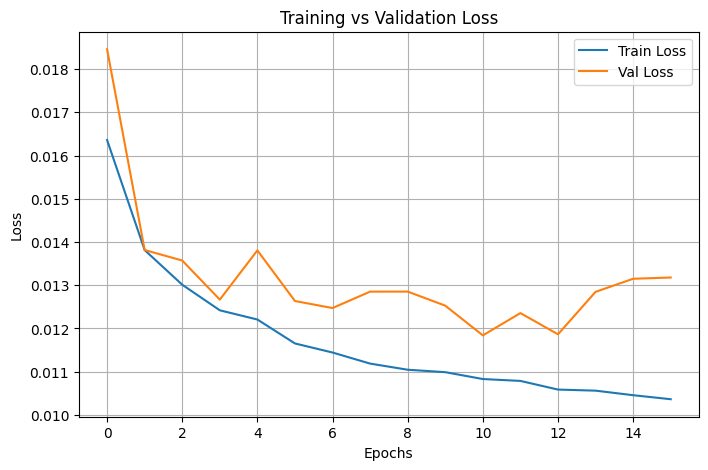

In [ ]:
plot_losses(train_losses, val_losses)

In [ ]:
# Function to visualize raw, predicted, and target images

def show_images(raw, predicted, target, idx=None):
    raw = raw.detach().cpu().permute(1, 2, 0).numpy()
    predicted = predicted.detach().cpu().permute(1, 2, 0).numpy()
    target = target.detach().cpu().permute(1, 2, 0).numpy()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    titles = ["Raw Input", "Predicted Output", "Target"]

    for ax, img, title in zip(axes, [raw, predicted, target], titles):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis("off")
    plt.show()

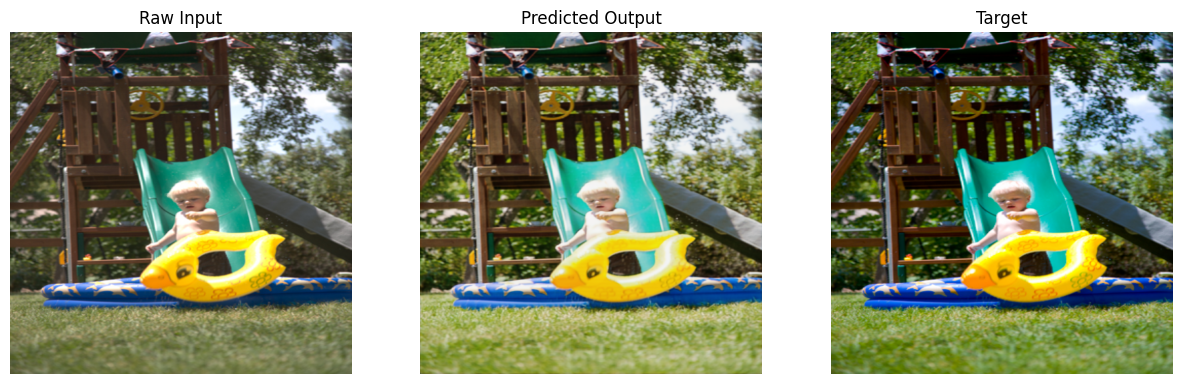

In [ ]:
model.eval()
with torch.no_grad():
    for raw, target in val_loader:
        raw, target = raw.to(device), target.to(device)
        outputs = model(raw)

        # Show first sample in the batch
        show_images(raw[0], outputs[0], target[0])
        break

In [ ]:
# define function to evaluate on test set

def evaluate_test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for raw_imgs, target_imgs in test_loader:
            raw_imgs, target_imgs = raw_imgs.to(device), target_imgs.to(device)
            with torch.cuda.amp.autocast():
                outputs = model(raw_imgs)
                loss = criterion(outputs, target_imgs)
            test_loss += loss.item()
    test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f}")
    
    raw, target = next(iter(test_loader))
    raw, target = raw.to(device), target.to(device)
    with torch.no_grad():
        outputs = model(raw)
    show_images(raw[5], outputs[5], target[5])


## 🎨 Results
Here we display some qualitative results comparing:
- Raw input image  
- Predicted corrected output  
- Ground truth target image  


/tmp/ipykernel_19/1261752120.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Test Loss: 0.0119


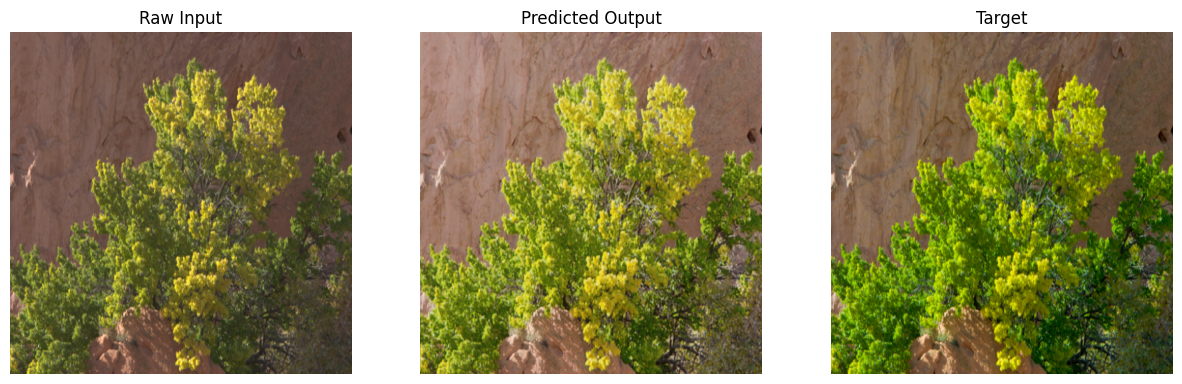

In [ ]:
evaluate_test(model, test_loader, criterion, device)